In [ ]:
# getting The dataset 

# https://neptune.ai/blog/google-colab-dealing-with-files
!echo '{"username":"hazarre","key":"92000f46465441bb5d82fcd2dd3765d9"}' > ~/.kaggle/kaggle.json #write kaggle API credentials to kaggle.json
!chmod 600 ~/.kaggle/kaggle.json  # set permissions
!pip install --upgrade --force-reinstall --no-deps kaggle


Processing /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10/kaggle-1.5.10-cp36-none-any.whl
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [ ]:
# set up environment
import math, re, os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt  
from IPython import display


In [ ]:
!kaggle competitions download rfcx-species-audio-detection 

100% 49.6G/49.7G [07:49<00:00, 112MB/s]
100% 49.7G/49.7G [07:49<00:00, 114MB/s]


In [ ]:
!unzip rfcx-species-audio-detection.zip

In [ ]:
# Get the files 
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = "../content/"
BATCH_SIZE = 16
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/train/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test/*.tfrec')

In [ ]:
# Obtain audio data and turn into fixed size spectrogram for training  

def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def string_split_semicolon(column):
    split_labels_sc = tf.strings.split(column, sep=';')
    return split_labels_sc

def string_split_comma(column):
    split_labels_c = tf.strings.split(column, sep=',')
    return split_labels_c

def get_spectrogram(waveform, eq_size=None):
#     zero_padding = tf.zeros([eq_size] - tf.shape(waveform), dtype=tf.float32)
#     waveform = tf.cast(waveform, tf.float32)
#     equal_length = tf.concat([waveform, zero_padding], 0)
    equal_length = waveform
    spectrogram = tf.signal.stft(equal_length, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "audio_wav"    : tf.io.FixedLenFeature([], tf.string), 
        "label_info"   : tf.io.FixedLenFeature([], tf.string) 
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    audio = decode_audio(example['audio_wav'])
    first_split = string_split_semicolon(example['label_info'])
    remove_quotes = tf.strings.regex_replace(first_split, '"', "") 
    
    second_split = string_split_comma(remove_quotes) 
    labels = tf.strings.to_number(second_split)
    
    species_id = tf.cast( tf.gather_nd(labels, [0, 0]) , tf.int32)
    songtype_id = tf.gather_nd(labels,[0, 1])
    t_min = tf.gather_nd(labels, [0, 2]) 
    f_min = tf.gather_nd(labels, [0, 3])
    t_max = tf.gather_nd(labels, [0, 4]) 
    f_max = tf.gather_nd(labels, [0, 5])
    is_tp = tf.cast( tf.gather_nd(labels, [0, 6]), tf.bool)
    
    sr = tf.constant(48000,  dtype=tf.float32)
    eq = tf.constant(.27,  dtype=tf.float32)
    eq_size = tf.cast( tf.math.ceil(eq*sr), tf.int32)
    
    # chop the audio section of interest 
    begin = [tf.cast(t_min*sr, tf.int32)]
#     size =  tf.cast( tf.math.ceil(t_max*sr-t_min*sr), tf.int32)
    audio = tf.slice(audio, begin=begin, size=[eq_size])
    
    # get a fixed sized spectrogram of eq_size
    audio = get_spectrogram(audio, eq_size)
    
    ns = tf.concat( [tf.shape(audio), [1]],0)

    audio = tf.reshape(audio, ns)
    return audio, species_id #, t_min , f_min, t_max, f_max, is_tp

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "recording_id" : tf.io.FixedLenFeature([], tf.string),      
        "audio_wav"    : tf.io.FixedLenFeature([], tf.string) 
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    audio = decode_audio(example['audio_wav'])
    idnum = example['recording_id']
    sr = tf.constant(48000,  dtype=tf.float32)
    eq = tf.constant(.27,  dtype=tf.float32)
    eq_size = tf.cast( tf.math.ceil(eq*sr), tf.int32)
    specs = []
    for t_min in np.arange(start=0, stop=60-.27, step=.27 ): 
        t_min  = tf.constant(t_min,  dtype=tf.float32)
        # chop the audio section of interest 
        begin = [tf.cast(t_min*sr, tf.int32)]
        #     size =  tf.cast( tf.math.ceil(t_max*sr-t_min*sr), tf.int32)
        roi = tf.slice(audio, begin=begin, size=[eq_size])
        # get a fixed sized spectrogram of eq_size
        roi = get_spectrogram(roi, eq_size)
        ns = tf.concat( [tf.shape(roi), [1]],0)
        roi = tf.reshape(roi, ns)
        specs.append(roi)
    return specs, idnum

def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False  
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) 
    dataset = dataset.with_options(ignore_order)  
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset 

def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.repeat()  
    dataset = dataset.shuffle(128)
#     dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE) 
    return dataset

def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)


NUM_TRAINING_FILES = count_data_items(TRAINING_FILENAMES)
NUM_TEST_FILES = count_data_items(TEST_FILENAMES)

print('Dataset: {} training files, {} unlabeled test files'.format(NUM_TRAINING_FILES, NUM_TEST_FILES))

# for audio, species_id in get_training_dataset().take(3):
#     print(audio.numpy().shape, species_id.numpy().shape)

for audio, species_id  in get_training_dataset().take(1):
    print("\naudio examples:", audio.shape, audio)                 # (16,2880000)
    print("species_id examples:", species_id.numpy())  # (16,)
#     print("t_min:", t_min)
#     print("f_min:", f_min.numpy())
#     print("t_max:", t_max.numpy())
#     print("f_max:", f_max.numpy())
#     print("is_tp:", is_tp.numpy())

In [ ]:
# Check input shape
spectrogram_ds = get_training_dataset()

train_ds = spectrogram_ds

batch_size = 64
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(AUTOTUNE)

for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = 24

Input shape: (100, 129, 1)


In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
import timeit

start = timeit.default_timer()
norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.take(NUM_TRAINING_FILES).map(lambda x, _: x)) #NUM_TRAINING_FILES
print("time for Normalization: ", timeit.default_timer() - start)

time for Normalization:  251.03111999799967


In [ ]:
 # Basic model
 model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,

    # Feature Extraction
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    #
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing (Resizing)          (None, 32, 32, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

Epoch 1/5
140/140 [==============================] - 477s 3s/step - loss: 3.1373 - accuracy: 0.1004
Epoch 2/5
140/140 [==============================] - 469s 3s/step - loss: 2.8976 - accuracy: 0.1696
Epoch 3/5
140/140 [==============================] - 469s 3s/step - loss: 2.7487 - accuracy: 0.2030
Epoch 4/5
140/140 [==============================] - 469s 3s/step - loss: 2.5967 - accuracy: 0.2477
Epoch 5/5
140/140 [==============================] - 469s 3s/step - loss: 2.4400 - accuracy: 0.2886


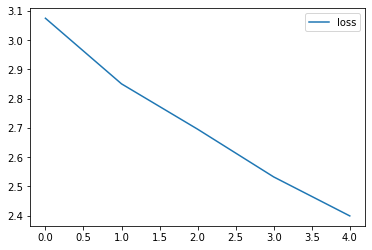

In [ ]:
# Training
EPOCHS = 5
history = model.fit(
    train_ds, 
#     validation_data=val_ds,  
    epochs=EPOCHS,
    steps_per_epoch = 140
#     callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

metrics = history.history
plt.plot(history.epoch, metrics['loss'])
plt.legend(['loss'])
plt.show()

In [ ]:
test_ds = load_dataset(TEST_FILENAMES, labeled=False)

In [ ]:
data = []
count = 0
start = timeit.default_timer()

for specs, idnum in test_ds.take(NUM_TEST_FILES):
    pred =  tf.map_fn(fn=lambda spec:  tf.nn.softmax( np.amax( model.predict(specs), axis = 0)) , elems=specs)
    pred =  np.amax(pred, axis =0)
    stop = timeit.default_timer() 
    data.append( [idnum.numpy().decode("utf-8")] + list(pred))
    count +=1
    print(count, idnum.numpy().decode("utf-8"), 'Time: ', stop - start)
cols = ["recording_id"] + [ "s%s" %i for i in range(24) ]
df = pd.DataFrame(data=data,columns = cols  )
df.head()

1 226daf7a4 Time:  55.828077701999064
2 226fdd52e Time:  103.92900121799903
3 228ec2e44 Time:  153.5417958049984
4 229445f97 Time:  202.64299214499988
5 22bf34d57 Time:  251.45924358999946
6 231b751a6 Time:  300.27364485399994
7 232fe3b6f Time:  349.2098851589999
8 2341a29ca Time:  397.98215767299916
9 235e518ce Time:  447.2739246489982
10 23802a50e Time:  496.01167025499853
11 23bd773d5 Time:  544.9050977869992
12 23f85e34a Time:  593.7784040649985
13 240697131 Time:  642.7010281599996
14 2420703df Time:  691.4885385039997
15 2444fbf36 Time:  740.2040522839998
16 245efe45c Time:  789.5838958329987
17 24968153e Time:  838.3854623169991
18 2497b42b0 Time:  888.1600980699986
19 24a1c2d43 Time:  936.8687489899985
20 24c2dcbde Time:  985.838462923999
21 24d2831ba Time:  1034.619902818
22 24e0357d3 Time:  1083.9774758509993
23 25031e403 Time:  1132.800068437
24 251b20553 Time:  1181.8153379319992
25 252305b36 Time:  1231.2227767779987
26 2557f807f Time:  1280.0308770229985
27 256bbb887 Time

In [ ]:
assert df.shape[0] == NUM_TEST_FILES

In [ ]:
print(specs.shape)

In [ ]:
print(specs.numpy()[0].shape)

In [ ]:
df.to_csv("submission.csv", index=False)
from google.colab import files
files.download('submission.csv')